# RUL Prediction - Alternatives

# Libs

In [228]:
import os
import re
import sys
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time   
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
 
from fitter import Fitter, get_common_distributions, get_distributions

from collections import Counter
import missingno as mn 
import random
from copy import deepcopy 

from sklearn import ensemble 
from sklearn import tree  
from sklearn import kernel_ridge

from sklearn.preprocessing import scale

from sklearn import linear_model 
from sklearn import decomposition
from sklearn import svm 
import catboost  
import lightgbm 

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV 

from scipy.stats import pearsonr 
from dtaidistance import dtw, dtw_ndim
from kneed import DataGenerator, KneeLocator
from  sklearn.feature_selection import VarianceThreshold

from statsmodels.tsa.stattools import adfuller 
from scipy.fft import fft, ifft
from IPython.display import display, Markdown, Image

from statsmodels.tsa.stattools import adfuller 
from scipy.fft import fft, ifft
from IPython.display import display, Markdown, Image
import seaborn as sns; sns.set()

from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

# Load Data

In [98]:
current = os.getcwd() 
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
 
PROJECT_PATH = os.getcwd() + "/gifs"  
CODE_PATH =os.getcwd() + "/Classes"   
current = os.getcwd() 
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.insert(0, f"{parent_folder}\Classes") # 
from menu_A_a_data_utility import DataUtility 
#from memu_D_features import SelectingEDAFeatures

In [6]:
def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] #list 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001") 

# Define "Output" -- RUL
* visualize rul distributions and test it. 

## Life Time

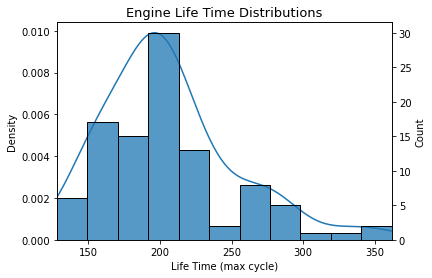

In [10]:
tmp = DF_TRAIN.copy()
tmp = DF_TRAIN.groupby("id")["cycle"].max().reset_index()
 
fig, ax1 = plt.subplots()
kde_data = sns.kdeplot(data=tmp, x="cycle", ax=ax1)

ax1.set_xlim((tmp["cycle"].min(), tmp["cycle"].max()))
ax2 = ax1.twinx()

sns.histplot(data=tmp, x="cycle", discrete=False, ax=ax2)
plt.grid(False)
plt.title("Engine Life Time Distributions", fontsize=13)
ax1.set_xlabel("Life Time (max cycle)")
plt.show()

## check distribution

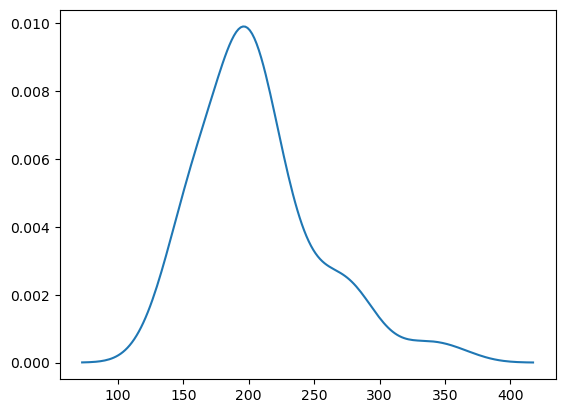

In [8]:
line = kde_data.lines[0]
x, y = line.get_data() 
fig, ax = plt.subplots()
ax.plot(x[x>0], y[x>0]) 
plt.show()

In [8]:
f = Fitter(y,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary() 
f.get_best(method = 'sumsquare_error') 

Fitting 5 distributions: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


{'lognorm': {'s': 1.9233553715087806,
  'loc': -5.549389987306902e-06,
  'scale': 0.00097851480043475}}

**lognorm:**
* In reliability analysis, the log-normal distribution is often used to model times to repair a maintainable system
* The length of comments posted in Internet discussion forums follows a log-normal distribution

In [14]:
def load_data(flags = None):
    uti = DataUtility()
    df_train, df_test, df_result = uti.prepare_dfs()
    df_train["rul"] = df_train.groupby(["Flag","id"])["cycle"].transform("max")-df_train["cycle"]
    
    if not flags:
        return df_train, df_test, df_result
    if type(flags) == str:
        flags = [flags] #list 
    return df_train[df_train["Flag"].isin(flags)],df_test[df_test["Flag"].isin(flags)],df_result[df_result["Flag"].isin(flags)]

DF_TRAIN, DF_TEST, DF_RESULT = load_data(flags = "FD001")  

# Alternatives  - Similarity

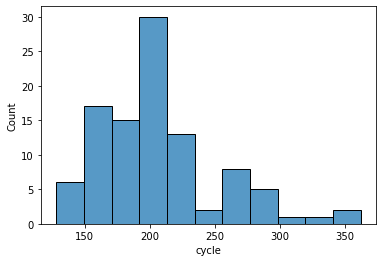

In [7]:
# engine life time 
tmp = DF_TRAIN.copy()
sns.histplot(data=tmp.groupby("id")["cycle"].max().reset_index(), x="cycle")
plt.show()

### Time series
* The reason for trying to stationarize a time series is to be able to obtain meaningful sample statistics such as means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary. For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables. For this reason you should be cautious about trying to extrapolate regression models fitted to nonstationary data.

* Most business and economic time series are far from stationary when expressed in their original units of measurement, and even after deflation or seasonal adjustment they will typically still exhibit trends, cycles, random-walking, and other non-stationary behavior.   

* If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g., by fitting a trend line and subtracting it out prior to fitting a model, or else by including the time index as an independent variable in a regression or ARIMA model), perhaps in conjunction with logging or deflating.   Such a series is said to be trend-stationary.    However, sometimes even de-trending is not sufficient to make the series stationary, in which case it may be necessary to transform it into a series of period-to-period and/or season-to-season differences.  If the mean, variance, and autocorrelations of the original series are not constant in time, even after detrending, perhaps the statistics of the changes in the series between periods or between seasons will be constant.   Such a series is said to be difference-stationary.  (Sometimes it can be hard to tell the difference between a series that is trend-stationary and one that is difference-stationary, and a so-called unit root test may be used to get a more definitive answer.  We will return to this topic later in the course.)

尝试使时间序列平稳化的原因是能够获得有意义的样本统计数据，例如均值、方差以及与其他变量的相关性。仅当序列是平稳的时，此类统计数据才可用作未来行为的描述符。例如，如果序列随时间持续增加，则样本均值和方差将随着样本的大小而增长，并且它们将始终低估未来时期的均值和方差。如果一个序列的均值和方差没有明确定义，那么它与其他变量的相关性也没有。出于这个原因，您应该谨慎尝试外推适合非平稳数据的回归模型。

大多数商业和经济时间序列在以其原始计量单位表示时远非平稳，即使在通货紧缩或季节性调整之后，它们通常仍会表现出趋势、周期、随机游走和其他非平稳行为。

如果该序列具有稳定的长期趋势并且倾向于在干扰后恢复到趋势线，则可以通过去趋势（例如，通过拟合趋势线并在拟合模型之前将其减去）使其平稳化，或者通过将时间索引作为自变量包含在回归或 ARIMA 模型中），可能与日志记录或放气结合使用。据说这样的系列是趋势平稳的。然而，有时即使去趋势化也不足以使序列平稳，在这种情况下，可能有必要将其转换为一系列不同时期和/或不同季节的差异。如果原始序列的均值、方差和自相关在时间上不是恒定的，即使在去趋势化之后，也许序列在不同时期或季节之间的变化统计量将是恒定的。这样的序列被称为差异平稳的。 （有时很难区分趋势平稳序列和差异平稳序列之间的区别，可以使用所谓的单位根检验来获得更明确的答案。我们将回到这个主题在课程的后面。）

## Stationarity
* use adf, augmented dickey-fuller test. Determine whether a unit root (a feature that can cause issues in statistical inference) is present in an autoregressive model
* Stationary data refers to the time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data
* H0: there is one unit root. not stationary
* H1: there is not. statationary
* autolag:   {"AIC", "BIC", "t-stat", None} Method to use when automatically determining the lag length among the values 0, 1, ..., maxlag.

* 使用 adf，增强的 dickey-fuller 测试。 确定单位根（可能导致统计推断问题的特征）是否存在于自回归模型中
* 平稳数据是指均值和方差不随时间变化的时间序列数据。 如果从数据中观察到强烈的趋势或季节性，则认为数据是非平稳的
* H0：有一个单位根。 不是静止的
* H1：没有。 静止的
* autolag: {"AIC", "BIC", "t-stat", None} 自动确定值 0、1、...、maxlag 之间的滞后长度时使用的方法。

In [8]:
from statsmodels.tsa.stattools import adfuller 

In [9]:
tmp = DF_TRAIN.copy()

In [14]:
p = adfuller(tmp[tmp["id"]==12]["sensor21"], autolag="AIC")[1]
p

0.9952190715758297

In [16]:
FEATS = [c for c in list(tmp) if re.match("sen", c)]

In [50]:
def make_stationary():
    tmp = DF_TRAIN.copy()

    signif = 0.05
    dicts  ={}

    for engine in tmp["id"].unique():
        for col in FEATS:
            diff = 0 
            while diff < 4:
                vals = tmp[tmp["id"]==engine][col]
                vals = np.append([np.nan]*diff, np.diff(vals, n=diff))
                p = adfuller(vals[diff:], autolag="AIC")[1]
                if p < signif:  
                    if col not in dicts:
                        dicts[col] = [diff]
                    else:
                        dicts[col].append(diff) 
                    break
                diff += 1

    diff_needs = {k:Counter(v).most_common(1)[0][0] for k,v in dicts.items()}
    
    tmp1 = tmp.copy()
    for k,v in diff_needs.items():
        if v == 0:
            tmp1[k] = tmp1[k]
        else:
            tmp1[k] = np.append([np.nan]*v, np.diff(tmp1[k], n=v))
        
    return diff_needs, tmp1

diff_needs, stationed_df = make_stationary() 

In [39]:
def station_test(df): 
    tmp = DF_TEST.copy()
    
    for k,v in diff_needs.items():
        if v == 0:
            tmp[k] = tmp[k]
        else:
            tmp[k] = np.append([np.nan]*v, np.diff(tmp[k], n=v))
        
    return tmp


### stationarized

In [51]:
#stationed_df[FEATS] = stationed_df[FEATS].fillna(method="bfill")
stationed_df.dropna(inplace=True)
X = stationed_df[FEATS].values
y = stationed_df["rul"]
bgr = ensemble.GradientBoostingRegressor(criterion="friedman_mse", learning_rate=0.1, alpha=0.9)
bgr.fit(X,y)

GradientBoostingRegressor()

In [58]:
test = DF_TEST.copy()
test = station_test(test)
#test[FEATS] = test[FEATS].fillna(method="bfill")
test.dropna(inplace=True)
preds = bgr.predict(test[FEATS])
y_test = test.pop("remaining_rul")
r2 = np.corrcoef(np.array(preds), np.array(y_test))
print(r2[0][1]) 

0.08437970375168233


### original

In [53]:
tmp = DF_TRAIN.copy() 
X = tmp[FEATS].values
y = tmp["rul"]
bgr = ensemble.GradientBoostingRegressor(criterion="friedman_mse", learning_rate=0.1, alpha=0.9)
bgr.fit(X,y)

GradientBoostingRegressor()

0.6334548362312081


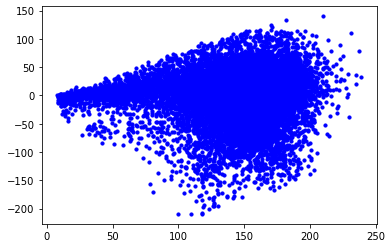

In [54]:
test = DF_TEST.copy()
y_test = test.pop("remaining_rul")
preds = bgr.predict(test[FEATS])
plt.scatter(preds, preds - y_test, color = "blue", s = 10, label = 'Test data')
r2 = np.corrcoef(np.array(preds), np.array(y_test))
print(r2[0][1])
plt.show()

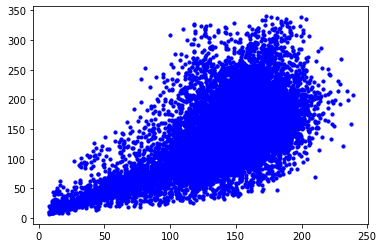

In [55]:
preds = bgr.predict(test[FEATS])
plt.scatter(preds, y_test,
                color = "blue", s = 10, label = 'Test data')
plt.show()

In [56]:
from scipy.stats.stats import pearsonr 
print(pearsonr(np.array(preds), np.array(y_test)))
np.corrcoef(np.array(preds), np.array(y_test))

PearsonRResult(statistic=0.6334548362312085, pvalue=0.0)


array([[1.        , 0.63345484],
       [0.63345484, 1.        ]])

## Linear models with ewm

* take ewm  
* and then cut at N for models
* ewm by cycle 

In [72]:
tmp = DF_TRAIN.copy()
N = 150 # clip
alpha=0.4

In [73]:

tmp2 = tmp.groupby('id')[FEATS].apply(lambda x: x.ewm(alpha=alpha).mean())
tmp2 = pd.concat([tmp[["id", "cycle", "rul"]], tmp2], axis=1)
#tmp2 = tmp2[tmp2["rul"]<=N]
tmp2["rul"] = tmp2["rul"].clip(upper=N) 

### Scaling

In [74]:
feats = deepcopy(FEATS)
#feats.append("cycle")

X = tmp2[feats].values
#mn = MinMaxScaler()
tmp2["health"] = tmp2.groupby("id")["rul"].transform(lambda x: minmax_scale(x)) 
y = tmp2["health"]
bgr = ensemble.GradientBoostingRegressor(criterion="friedman_mse", learning_rate=0.1, alpha=0.9)
bgr.fit(X,y) 

GradientBoostingRegressor()

* results

In [79]:
xtest = DF_TEST.copy()
xtest["health"] = xtest.groupby("id")["remaining_rul"].transform(lambda x: minmax_scale(x)) 
net_feats = deepcopy(FEATS)
y1 = xtest.pop('health')

xtest[net_feats] = xtest.groupby('id')[net_feats].apply(lambda x: x.ewm(alpha=alpha).mean())
xtest  = xtest[net_feats]
pp = bgr.predict(xtest)

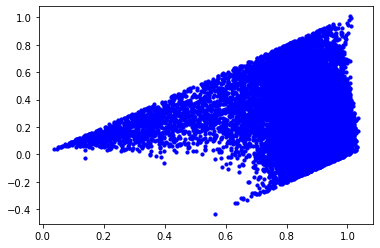

In [80]:
 
plt.scatter(pp, pp - y1, color = "blue", s = 10, label = 'Test data')
plt.show()

In [81]:
from scipy.stats.stats import pearsonr 
print(pearsonr(np.array(pp), np.array(y1)))
np.corrcoef(np.array(pp), np.array(y1))

PearsonRResult(statistic=0.5648712450303209, pvalue=0.0)


array([[1.        , 0.56487125],
       [0.56487125, 1.        ]])

### Clip

In [83]:

X = tmp2[feats].values
#mn = MinMaxScaler() 
y = tmp2["rul"]
bgr = ensemble.GradientBoostingRegressor(criterion="friedman_mse", learning_rate=0.1, alpha=0.9)
bgr.fit(X,y) 

GradientBoostingRegressor()

In [86]:
xtest = DF_TEST.copy()
y_test = xtest.pop("remaining_rul")
xtest  = xtest[net_feats]
pp = bgr.predict(xtest)
print(pearsonr(np.array(pp), np.array(y_test)))


PearsonRResult(statistic=0.6303720563514819, pvalue=0.0)


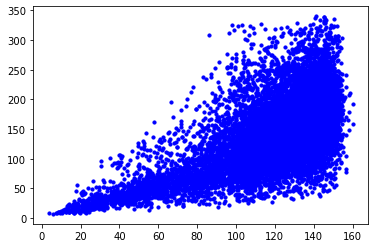

In [87]:
 
plt.scatter(pp, y_test, color = "blue", s = 10, label = 'Test data')
plt.show()

## Dtw: dynamic time warping

### Concept
* In time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences, which may vary in speedIn time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences, which may vary in speed. 在时间序列分析中，动态时间规整（DTW）是一种用于衡量两个时间序列之间相似性的算法，时间序列可能在速度上有所不同在时间序列分析中，动态时间规整（DTW）是一种用于衡量两个时间序列之间相似性的算法，时间序列可能在速度上有所不同

* Two repetitions of a walking sequence recorded using a motion-capture system. While there are differences in walking speed between repetitions, the spatial paths of limbs remain highly similarTwo repetitions of a walking sequence recorded using a motion-capture system. While there are differences in walking speed between repetitions, the spatial paths of limbs remain highly similar 使用动作捕捉系统记录两次重复的步行序列。 虽然重复之间的步行速度存在差异，但四肢的空间路径仍然高度相似使用动作捕捉系统记录两次重复的步行序列。 虽然重复之间的步行速度存在差异，但四肢的空间路径仍然高度相似

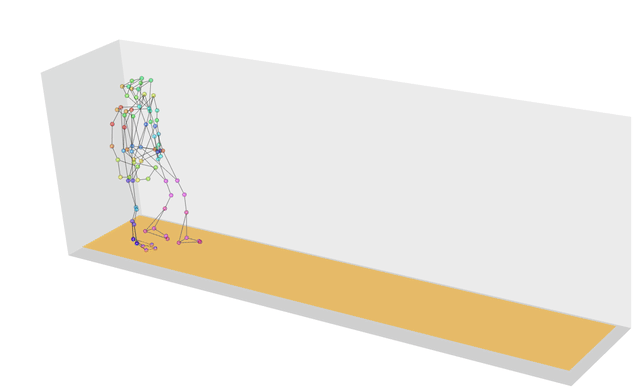

In [15]:
dtw_file = PROJECT_PATH + '/dtw.gif'
Image(dtw_file) 
# ref: https://en.wikipedia.org/wiki/Dynamic_time_warping

### Calculate

In [88]:
alpha= 0.5
def corr_feature_cycle(col, df): 
    trend_vals = [] 
    for i in df["id"].unique():
        dff = df[df["id"] == i]
        trend_vals.append(df[['cycle', col]].corr().iloc[0][1]) 
    return np.abs(np.mean(trend_vals))

def get_trends(thresh=0.10, show_graph=True):
    trend_df = pd.DataFrame(columns = ['feature', 'trendability_val']) 
    tmp = DF_TRAIN.copy()
    feats= deepcopy(FEATS) # round_one_final()   
    tmp[feats] = tmp.groupby('id')[feats].apply(lambda x: x.ewm(alpha=alpha).mean())
    for col in feats:
        trend_df = trend_df.append({'feature': col, 'trendability_val': corr_feature_cycle(col, df = tmp)}, ignore_index = True) 
 
    trend_df = trend_df.sort_values(by = 'trendability_val', ascending = False)
    
    if show_graph:
        fig, ax = plt.subplots(figsize = (7,10)) 
        sns.barplot(y = trend_df.feature, x = trend_df.trendability_val)

        for container in ax.containers:
            ax.bar_label(container, fontsize=12, color="blue", fmt='%g')

        plt.show()
    
    #trend_df = trend_df[trend_df.trendability_val > thresh]
  
    return trend_df 

In [119]:
def similarity_by_dtw():
    trend_df = get_trends(show_graph = False)

    dict_trend = trend_df.to_dict(orient='dict') 
    keys = dict_trend["feature"].values()
    values = dict_trend["trendability_val"].values()
    weights = {k:v for k,v in zip(keys, values)}

    tr = DF_TRAIN.copy()
    tt =  DF_TEST.copy();
    tr[FEATS] = tr[FEATS].astype(float) 
    tt[FEATS] = tt[FEATS].astype(float)   
    vals = [] 
    for test_engine in tt["id"].unique(): 
        minlen = tt[tt["id"]==test_engine].shape[0] 
        for engine in tr[tr["rul"]>=minlen]["id"].unique():
            for col in FEATS: 
                avg = tr[(tr["id"]==engine)&(tr["rul"]<=minlen)][col].mean()
                dis = dtw.distance_fast(tt[tt["id"]==test_engine][col].values, tr[tr["id"]==engine][col].values)
                vals.append((test_engine, col, engine, avg, dis, weights[col], np.abs(dis/avg*(weights[col]))))

    df_similarity = pd.DataFrame(vals, columns = ["test_id", "col", "train_id", "avg", "dtw_value", "weight", "dtw_distance"])
    # dtw_ndim.distance(tt[tt["id"]==test_engine][FEATS].values, tr[tr["id"]==engine][FEATS].values)
    
    return df_similarity


In [138]:
if 1111 == 111:
    df_similarity = similarity_by_dtw() 
    df_similarity.to_csv("c:/classes/pdm/materials/df_similarity.csv", index=False)
else:
    df_similarity = pd.read_csv("c:/classes/pdm/materials/df_similarity.csv")
df_similarity["weighted"] = df_similarity["dtw_value"]/df_similarity["avg"]

### Select Top N

In [209]:
dm = df_similarity.copy()
train = DF_TRAIN.copy()
topN = 80

aggdm = dm.groupby(["test_id","train_id"])["weighted"].sum().reset_index()  
aggdm["rank"] = aggdm.groupby("test_id")["weighted"].rank(method="first").astype(int)
aggdm.sort_values("rank", inplace=True)
aggdm[aggdm["test_id"]==1].head(2)

test=DF_TEST.copy()
last_test = test.groupby("id").last().reset_index()  
aggdm = aggdm.merge(last_test[["id","remaining_rul", "cycle"]], left_on="test_id", right_on="id", how="inner")
_ = aggdm.pop("id")
aggdm = aggdm.merge(train[["id", "cycle", "rul"]], left_on=["train_id", "cycle"], right_on=["id", "cycle"], how="inner")

predicted = aggdm[aggdm["rank"]<=topN].groupby("test_id").agg({"remaining_rul": "min", "rul":"mean"}).reset_index()
predicted[["remaining_rul", "rul"]].corr()

,remaining_rul,rul
remaining_rul,1.000000,0.618204
rul,0.618204,1.000000


### Find Knee

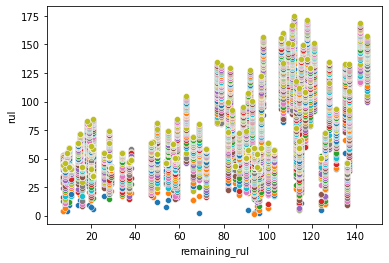

In [193]:

 
distances = []

for topN in range(1, aggdm["rank"].max()): 
    df_ = aggdm[aggdm["rank"]<=topN] 
    df_ = df_.groupby(["test_id", "remaining_rul"])["rul"].mean().reset_index()
    sns.scatterplot(df_["remaining_rul"], df_["rul"])
    distance = df_[["remaining_rul", "rul"]].corr()
    distances.append(distance.values[0][1]) 

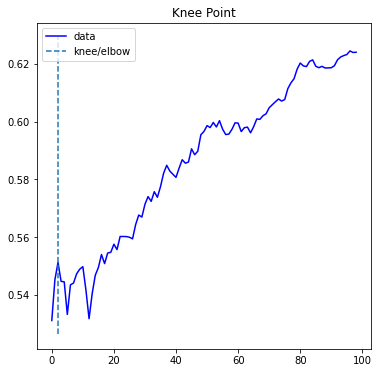

In [194]:
from kneed import KneeLocator  
kl = KneeLocator(range(len(distances)), distances, curve="concave")
kl.plot_knee()
plt.show()


### Try ndim


In [214]:
tr = DF_TRAIN.copy()
tt = DF_TEST.copy()

In [226]:
s2 =tr[(tr["id"]==1)&(tr["cycle"]<=100)][FEATS].values
s1 =tt[(tr["id"]==1)&(tt["cycle"]<=100)][FEATS].values 

In [227]:
from dtaidistance.dtw_ndim import distance
distance(s1,s2)

131.8642821390605

### KM
* The Kaplan-Meier estimate is the simplest way of computing the survival over time in spite of all these difficulties associated with subjects or situations. For each time interval, survival probability is calculated as the number of subjects surviving divided by the number of patients at risk.
* 尽管存在与受试者或情况相关的所有这些困难，Kaplan-Meier 估计是计算随时间推移的生存率的最简单方法。 对于每个时间间隔，存活概率计算为存活的受试者数量除以处于风险中的患者数量。

In [232]:
index_names = ['id', 'cycle']
setting_names = ['op1', 'op2', 'op3']
sensor_names = [c for c in list(DF_TRAIN) if re.match('sen', c)] 
col_names = index_names + setting_names + sensor_names

# breakdown
train = DF_TRAIN.copy() 
train['breakdown'] = 0

idx_last_record = train.reset_index().groupby(by='id')['index'].last()
train.loc[idx_last_record, 'breakdown'] = 1   
train["start"] = train['cycle'] - 1  

cut_off = 200 # make it right censored

train_censored = train[train['cycle'] <= cut_off].copy()

train_censored[train_censored["id"]==100]


,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,Flag,rul,breakdown,start
20431,100,1,-0.0033,0.0003,100.0,518.67,642.25,1596.57,1404.52,14.62,...,0.03,393,2388,100.0,38.72,23.3899,FD001,199,0,0
20432,100,2,0.0010,-0.0004,100.0,518.67,642.37,1589.43,1397.40,14.62,...,0.03,393,2388,100.0,39.18,23.2460,FD001,198,0,1
20433,100,3,0.0024,-0.0004,100.0,518.67,643.13,1588.55,1397.71,14.62,...,0.03,393,2388,100.0,38.95,23.2034,FD001,197,0,2
20434,100,4,0.0014,0.0001,100.0,518.67,642.33,1588.13,1397.93,14.62,...,0.03,393,2388,100.0,38.77,23.2495,FD001,196,0,3
20435,100,5,-0.0018,0.0003,100.0,518.67,641.90,1590.02,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.2351,FD001,195,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,0.03,397,2388,100.0,38.49,22.9735,FD001,4,0,195
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,0.03,395,2388,100.0,38.30,23.1594,FD001,3,0,196
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,0.03,398,2388,100.0,38.44,22.9333,FD001,2,0,197
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,0.03,395,2388,100.0,38.29,23.0640,FD001,1,0,198


#### curve

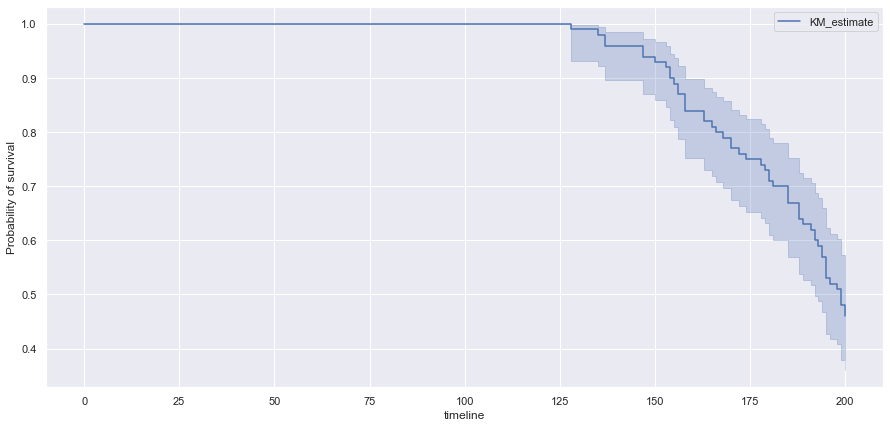

In [230]:
# create kaplan meier curve
data = train_censored[index_names+['breakdown']].groupby('id').last()

plt.figure(figsize=(15,7))
survival = KaplanMeierFitter()
survival.fit(data['cycle'], data['breakdown'])
survival.plot()
plt.ylabel("Probability of survival")
plt.show()
plt.close()

#### CoxTimeVaryingFitter
* Cox’s time varying proportional hazard model
Often an individual will have a covariate change over time. An example of this is hospital patients who enter the study and, at some future time, may receive a heart transplant. We would like to know the effect of the transplant, but we must be careful if we condition on whether they received the transplant. Consider that if patients needed to wait at least 1 year before getting a transplant, then everyone who dies before that year is considered as a non-transplant patient, and hence this would overestimate the hazard of not receiving a transplant.
 

Cox 时变比例风险模型
通常一个人会随着时间的推移发生协变量变化。 这方面的一个例子是进入研究并在未来某个时间可能接受心脏移植的住院患者。 我们想知道移植的效果，但如果以他们是否接受了移植为条件，我们必须小心。 考虑到如果患者在接受移植前至少需要等待 1 年，那么在那一年之前死亡的每个人都被视为非移植患者，因此这会高估不接受移植的风险。

refer to: https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html  for more details
有兴趣的同学，可以参照以上文档

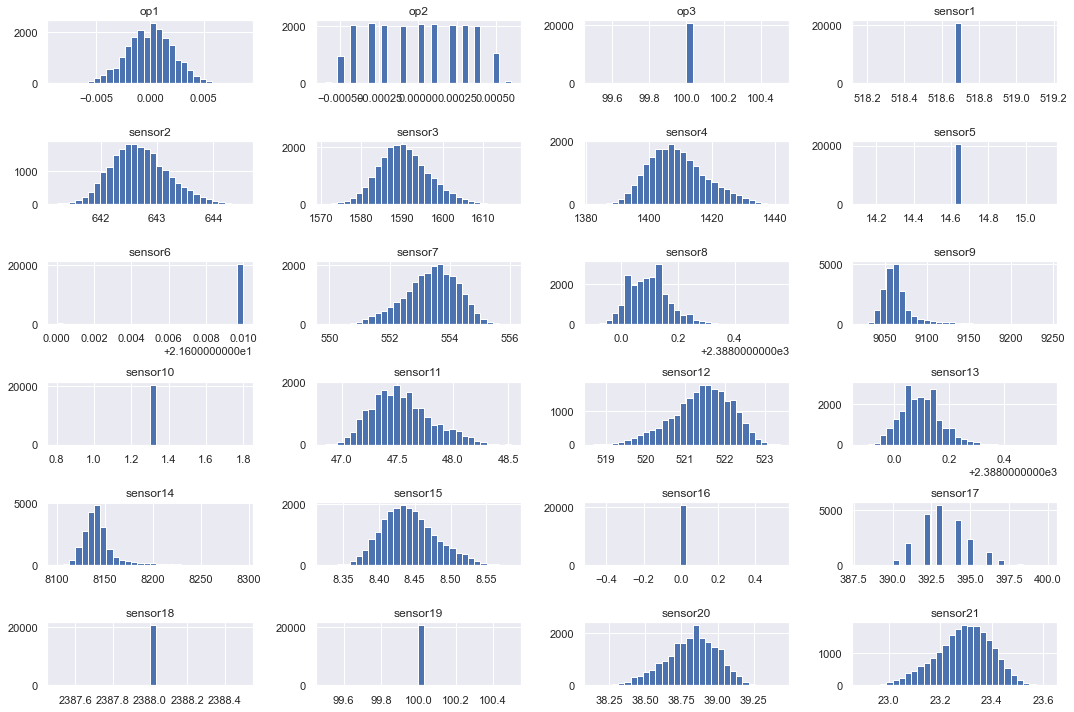

In [234]:
tmp = DF_TRAIN.copy()
tmp = tmp.select_dtypes(include = "number")
tmp.drop(columns = ["id", "cycle", "rul"], inplace = True) 
tmp.hist(bins=30, figsize=(15, 10),   layout=(-1, 4) ) 
plt.tight_layout()

Iteration 1: norm_delta = 0.90312, step_size = 0.95000, ll = -230.78680, newton_decrement = 107.16417, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.71741, step_size = 0.95000, ll = -109.79194, newton_decrement = 23.16688, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.67938, step_size = 0.95000, ll = -81.15203, newton_decrement = 10.29903, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.62899, step_size = 1.00000, ll = -68.53253, newton_decrement = 3.51558, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.30483, step_size = 1.00000, ll = -64.35996, newton_decrement = 0.45281, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.04796, step_size = 1.00000, ll = -63.86912, newton_decrement = 0.00890, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00100, step_size = 1.00000, ll = -63.86010, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -63.86010, newton_decrement = 0.00000, seconds_sinc

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>
         event col = 'breakdown'
number of subjects = 100
 number of periods = 18627
  number of events = 54
partial log-likelihood = -63.86
  time fit was run = 2022-11-26 06:52:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sensor2     2.05       7.75       0.72             0.64             3.45                 1.90                31.64
sensor3     0.07       1.07       0.04            -0.01             0.15                 0.99                 1.16
sensor4     0.16       1.18       0.05             0.07             0.26                 1.07                 1.29
sensor7    -1.09       0.34       0.50            -2.07            -0.11                 0.13                 0.90
sensor8    -5.03       0.01       4.84           -14.51             4.45                 0.00                85.79
sensor9    -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.05
sensor11    5.12     167.43       1.70             1.78             8.46                 5.95              4714.95
sensor12   -1.14       0.32       0.53            -2.17            -0.10                 0.11                 0.90
sensor13   12.90   3.99e+05       5.51             2.09            23.70                 8.09             1.97e+10
sensor14    0.04       1.04       0.04            -0.04             0.12                 0.96                 1.13
sensor15    5.07     159.96       9.53           -13.61            23.76                 0.00             2.09e+10
sensor17    0.41       1.51       0.20             0.01             0.81                 1.01                 2.25
sensor20   -5.13       0.01       2.02            -9.09            -1.17                 0.00                 0.31
sensor21   -4.23       0.01       2.67            -9.46             1.01                 0.00                 2.75

            cmp to     z      p   -log2(p)
covariate                                 
sensor2       0.00  2.85 <0.005       7.84
sensor3       0.00  1.73   0.08       3.57
sensor4       0.00  3.49 <0.005      11.03
sensor7       0.00 -2.17   0.03       5.06
sensor8       0.00 -1.04   0.30       1.74
sensor9       0.00 -0.58   0.56       0.82
sensor11      0.00  3.01 <0.005       8.56
sensor12      0.00 -2.15   0.03       4.99
sensor13      0.00  2.34   0.02       5.69
sensor14      0.00  0.95   0.34       1.54
sensor15      0.00  0.53   0.59       0.75
sensor17      0.00  2.03   0.04       4.56
sensor20      0.00 -2.54   0.01       6.49
sensor21      0.00 -1.58   0.11       3.14
---
Partial AIC = 155.72
log-likelihood ratio test = 333.85 on 14 df
-log2(p) of ll-ratio test = 205.97

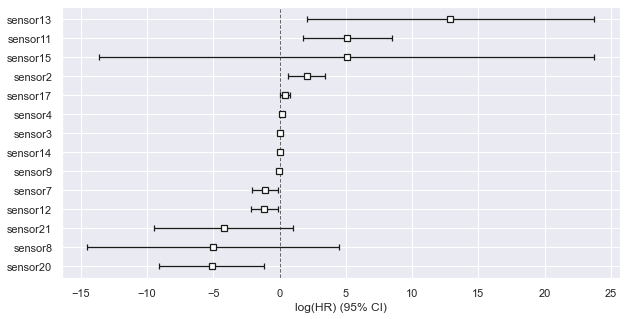

In [235]:
remaining_sen =[f"sensor{i}" for i in range(1, 22) if i not in [1,5,6,10,16,18,19]]
train_cols = index_names + remaining_sen + ['start', 'breakdown']
predict_cols = ['cycle'] + remaining_sen + ['start', 'breakdown']  # breakdown value will be 0

ctv = CoxTimeVaryingFitter()
ctv.fit(train_censored[train_cols], id_col="id", event_col='breakdown', 
        start_col='start', stop_col='cycle', show_progress=True) #  step_size=1 

ctv.print_summary()

plt.figure(figsize=(10,5))
ctv.plot()
plt.show()
plt.close()

In [236]:
display(ctv.summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sensor2,2.047076,7.745221,0.718074,0.639677,3.454475,1.895868e+00,3.164168e+01,0.0,2.850787,0.004361,7.841086
sensor3,0.070081,1.072595,0.040596,-0.009485,0.149647,9.905601e-01,1.161425e+00,0.0,1.726324,0.084289,3.568509
sensor4,0.164506,1.178811,0.047103,0.072187,0.256825,1.074856e+00,1.292819e+00,0.0,3.492513,0.000478,11.029196
sensor7,-1.086248,0.337480,0.500341,-2.066899,-0.105597,1.265777e-01,8.997871e-01,0.0,-2.171014,0.029930,5.062259
sensor8,-5.030594,0.006535,4.838076,-14.513049,4.451861,4.978093e-07,8.578643e+01,0.0,-1.039792,0.298436,1.744504
sensor9,-0.022045,0.978196,0.038271,-0.097054,0.052964,9.075067e-01,1.054392e+00,0.0,-0.576025,0.564598,0.824703
sensor11,5.120580,167.432485,1.703049,1.782666,8.458494,5.945689e+00,4.714952e+03,0.0,3.006714,0.002641,8.564766
sensor12,-1.136686,0.320881,0.528755,-2.173027,-0.100345,1.138325e-01,9.045255e-01,0.0,-2.149739,0.031576,4.985035
sensor13,12.897450,399292.512067,5.513918,2.090368,23.704531,8.087890e+00,1.971274e+10,0.0,2.339071,0.019332,5.692885


* Prediction

In [237]:
df = train_censored.groupby("id").last()
df = df[df['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df[df['breakdown'] == 0].copy()

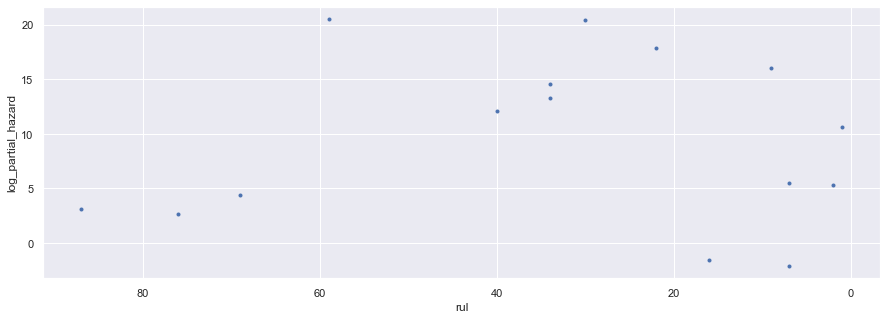

In [238]:
df = train_censored.groupby("id").last()
df = df[df['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df[df['breakdown'] == 0].copy()

predictions = pd.DataFrame(ctv.predict_log_partial_hazard(df_to_predict[predict_cols])) 
predictions.rename(columns={0: "predictions"}, inplace=True) 
df_last = train.groupby('id').last()
predictions['rul'] = df_to_predict['rul']  

plt.figure(figsize=(15,5))
plt.plot(predictions['rul'], predictions['predictions'], '.b')
xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('rul')
plt.ylabel('log_partial_hazard')

plt.show()

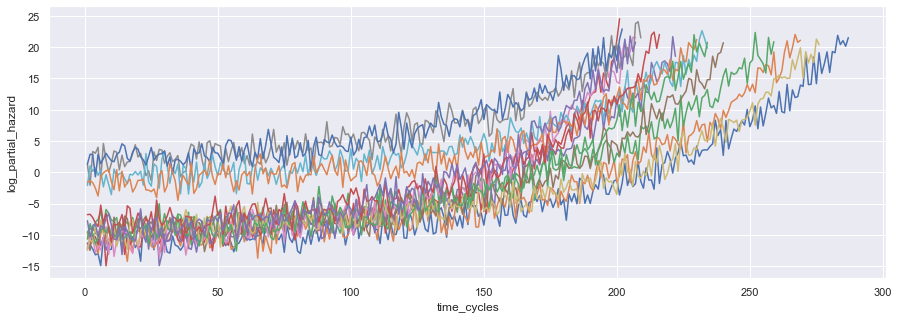

In [239]:
# now lets look at some hazard trajectories
X = train.loc[train['id'].isin(df_to_predict.index)]
X_unique = len(X['id'].unique())

plt.figure(figsize=(15,5))

#for i in range(1, X_unique, 2):
for i in range(1, X_unique):    
    X_sub = X.loc[X['id'] == i]
    if X_sub.shape[0] == 0:
        continue 
    predictions = ctv.predict_partial_hazard(X_sub).values
    plt.plot(X_sub['cycle'].values, np.log(predictions))

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


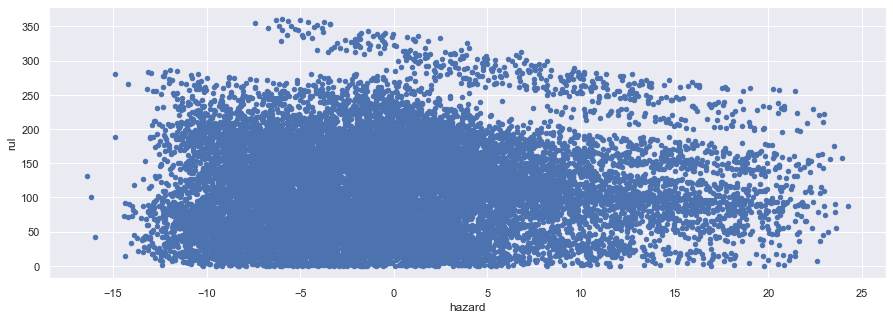

In [241]:
df_hazard = train_censored.copy()
df_hazard['hazard'] = ctv.predict_log_partial_hazard(df_hazard)
df_hazard.head()

df_hazard.plot('hazard', 'rul', 'scatter', figsize=(15,5))
plt.xlabel('hazard')
plt.ylabel('rul')
plt.show()

In [243]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    
from scipy.optimize import curve_fit

def exponential_model(z, a, b):
    return a * np.exp(-b * z)

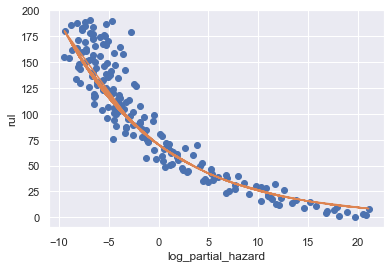

In [244]:
# check specific id
y_hat = exponential_model(df_hazard.loc[df_hazard['id']==1, 'hazard'], 70, 0.1)

plt.plot(df_hazard.loc[df_hazard['id']==1, 'hazard'], df_hazard.loc[df_hazard['id']==1, 'rul'], 'o',
        df_hazard.loc[df_hazard['id']==1, 'hazard'], y_hat)
plt.xlabel("log_partial_hazard")
plt.ylabel("rul")
plt.show()
plt.close()

In [245]:
popt, pcov = curve_fit(exponential_model, df_hazard['hazard'], df_hazard['rul'])
popt  # the coefficients

array([1., 1.])

In [247]:
# prep test set
X_test = DF_TEST.copy()
drop_cols =[col for col in list(X_test) if ( re.match('(op|sens)', col) and col not in remaining_sen)]
 
test = X_test.drop(labels=drop_cols, axis=1)
test['breakdown'] = 0
test['start'] = test['cycle'] - 1

# predict and evaluate
y_hat = exponential_model(df_hazard['hazard'], *popt)

tmp = df_hazard[["rul"]]
tmp["y_hat"] = y_hat
tmp.dropna(inplace=True)
tmp

evaluate(tmp['rul'], tmp["y_hat"], 'train')

y_pred = ctv.predict_log_partial_hazard(test.groupby('id').last())
y_hat = exponential_model(y_pred, *popt)
y_test = test.groupby("id")["remaining_rul"].last()
evaluate(y_test, y_hat)

train set RMSE:155752.09119353394, R2:-5487770.955081553
test set RMSE:26579.566160790102, R2:-409105.3606052353


#### Full ds

In [249]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(train[train_cols], id_col="id", event_col='breakdown', 
        start_col='start', stop_col='cycle', show_progress=True)

train['hazard'] = ctv2.predict_log_partial_hazard(train)
popt2, pcov2 = curve_fit(exponential_model, train['hazard'], train['rul'])

y_hat = exponential_model(train['hazard'], *popt2)
evaluate(train['rul'], y_hat, 'train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('id').last())
y_hat = exponential_model(y_pred, *popt2)
evaluate(y_test, y_hat)

Iteration 1: norm_delta = 1.00314, step_size = 0.95000, ll = -363.73938, newton_decrement = 168.94519, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.23297, step_size = 0.95000, ll = -196.95744, newton_decrement = 65.27103, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.74854, step_size = 0.95000, ll = -141.32406, newton_decrement = 25.30741, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.72741, step_size = 0.93100, ll = -129.43964, newton_decrement = 16.79179, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.22965, step_size = 1.00000, ll = -115.92018, newton_decrement = 1.13231, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.04043, step_size = 1.00000, ll = -114.78357, newton_decrement = 0.01240, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00056, step_size = 1.00000, ll = -114.77107, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -114.77106, newton_decrement = 0.00000, secon